# Feature Engeneering for ride duration of taxi trips in New York City

In this notebook we explore feature extraction to build a model that predicts the total ride duration of taxi trips in New York City. We are using data from a Kaggle competition (https://www.kaggle.com/c/nyc-taxi-trip-duration/).

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans
import warnings

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
plt.rcParams['figure.figsize'] = [13, 5]

## Initail data exploration

In [3]:
path = "/data/yinterian/nyc-taxi-trip-duration/"

In [4]:
train = pd.read_csv(path + 'train.csv')
#test = pd.read_csv(path + 'test.csv')

FileNotFoundError: File b'/data/yinterian/nyc-taxi-trip-duration/train.csv' does not exist

In [5]:
train.shape

(1458644, 11)

In [6]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Data Description
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
* trip_duration - duration of the trip in seconds

In [7]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


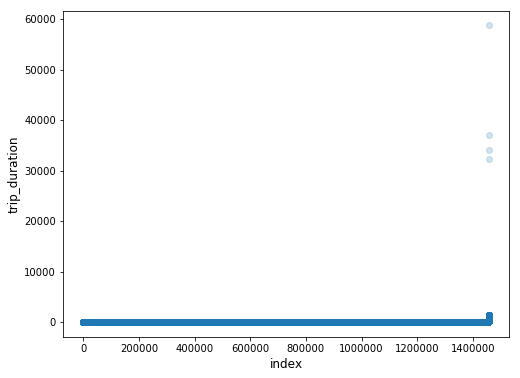

In [8]:
# let's look at the target variable
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train["trip_duration"].values/60), alpha=0.2)
plt.xlabel('index', fontsize=12)
plt.ylabel('trip_duration', fontsize=12)
plt.show()

In [9]:
# initial cleaning
train["trip_duration"].quantile([.0, 0.01, 0.25, .5, 0.75, 0.99, 1])

0.00          1.0
0.01         87.0
0.25        397.0
0.50        662.0
0.75       1075.0
0.99       3440.0
1.00    3526282.0
Name: trip_duration, dtype: float64

In [10]:
# The 99 quantile is 57. 3 minutes 
# getting rid of trips logger than one hour
deleted = train[train["trip_duration"] >= 60*60]
train = train[train["trip_duration"] < 60*60]
print(train.shape, deleted.shape)

(1446310, 11) (12334, 11)


In [11]:
# getting rid of trips shorter than one minute
train = train[train["trip_duration"] > 60]
print(train.shape)

(1437533, 11)


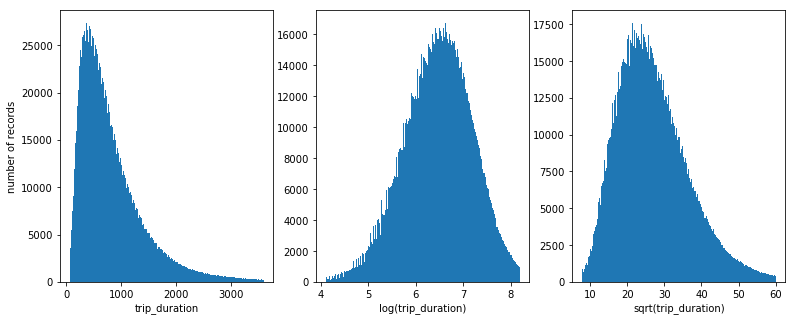

In [12]:
# It may be a good idea to transform the "y" variable
# Look for a transformation that give you a plot closer to a normal
train['log_trip_duration'] = np.log(train['trip_duration'].values)
train['sqrt_trip_duration'] = np.sqrt(train['trip_duration'].values)
fig, ax = plt.subplots(ncols=3, sharex=False, sharey=False)
ax[0].hist(train['trip_duration'].values, bins=200)
ax[1].hist(train['log_trip_duration'].values, bins=200)
ax[2].hist(train['sqrt_trip_duration'].values, bins=200)
ax[0].set_ylabel('number of records')
ax[0].set_xlabel('trip_duration')
ax[1].set_xlabel('log(trip_duration)')
ax[2].set_xlabel('sqrt(trip_duration)')
plt.show()

## Distance & Speed

In [13]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)

In [14]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,sqrt_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,21.330729
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.496775,25.748786
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661056,46.086874
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.061457,20.712315
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.075346,20.856654


In [15]:
# this formulas accepts nump arrays
from math import radians, cos, sin, asin, sqrt

def L2_distance(lon1, lat1, lon2, lat2):
    """
    """
    dlon = (lon2 - lon1)**2 
    dlat = (lat2 - lat1)**2
    return 1000*np.sqrt(dlon + dlat)

In [16]:
lon1 = train['pickup_longitude'].values 
lat1 = train['pickup_latitude'].values 
lon2 = train['dropoff_longitude'].values
lat2 = train['dropoff_latitude'].values

In [17]:
L2_distance(lon1[:4], lat1[:4], lon2[:4], lat2[:4])

array([ 17.6795395 ,  20.45590389,  59.93379941,  13.43820554])

In [18]:
train['distance'] = L2_distance(lon1, lat1, lon2, lat2)

In [19]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,sqrt_trip_duration,distance
count,1.437533e+06,1.437533e+06,1.437533e+06,1.437533e+06,1.437533e+06,1.437533e+06,1.437533e+06,1.437533e+06,1.437533e+06,1.437533e+06
mean,1.534866e+00,1.664864e+00,-7.397428e+01,4.075131e+01,-7.397384e+01,4.075206e+01,8.164712e+02,6.465014e+00,2.696299e+01,3.453177e+01
std,4.987830e-01,1.314656e+00,6.997894e-02,3.208705e-02,6.993927e-02,3.521628e-02,5.833988e+02,7.141824e-01,9.458772e+00,4.354683e+01
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,6.100000e+01,4.110874e+00,7.810250e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399191e+01,4.073762e+01,-7.399133e+01,4.073617e+01,3.990000e+02,5.988961e+00,1.997498e+01,1.266764e+01
50%,2.000000e+00,1.000000e+00,-7.398182e+01,4.075424e+01,-7.397979e+01,4.075462e+01,6.610000e+02,6.493754e+00,2.570992e+01,2.119937e+01
75%,2.000000e+00,2.000000e+00,-7.396768e+01,4.076840e+01,-7.396322e+01,4.076989e+01,1.064000e+03,6.969791e+00,3.261901e+01,3.797385e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.599000e+03,8.188411e+00,5.999167e+01,1.119260e+04


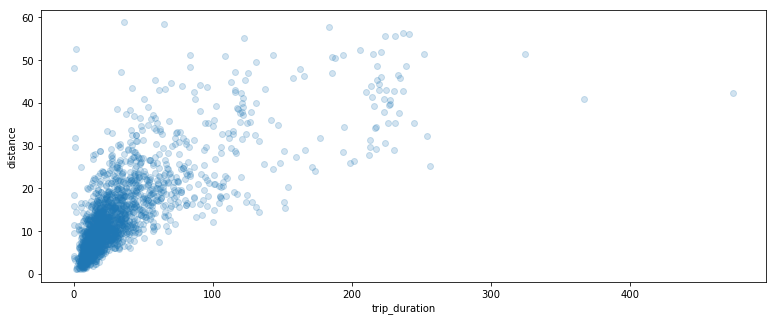

array([[ 1.        ,  0.74082196],
       [ 0.74082196,  1.        ]])

In [20]:
y = train['trip_duration'][:2000]/60
x = train['distance'][:2000]
plt.scatter(x, y, alpha=0.2)
plt.xlabel('trip_duration')
plt.ylabel('distance')
plt.show()
np.corrcoef(x,y)

In [21]:
# ?miles an hour
train["speed"] = train["distance"]/ (train["trip_duration"] / 360.0)

Note that 'speed' is not a feature since it needs trip duration which is the target variable.
We are using it just as part of our exploration

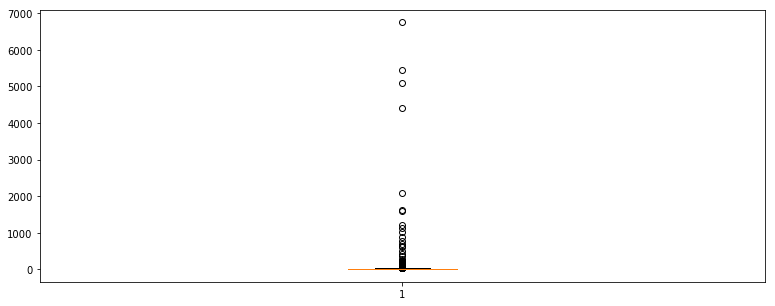

In [22]:
plt.boxplot(train['speed'])
plt.show()

In [23]:
# some more cleaning here
train['speed'].quantile([.0, 0.25, .5, 0.75, 0.999, 1])

0.000       0.000000
0.250       9.314723
0.500      12.944786
0.750      17.937170
0.999      55.765426
1.000    6749.747037
Name: speed, dtype: float64

In [24]:
train = train[train['speed'] < 60]

In [25]:
train.shape

(1436884, 15)

## Time features

We will define some time features. By plotting every feature agains the "trip_duration" or "speed" we will be able to see if there is any useful correlations. 

In [26]:
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

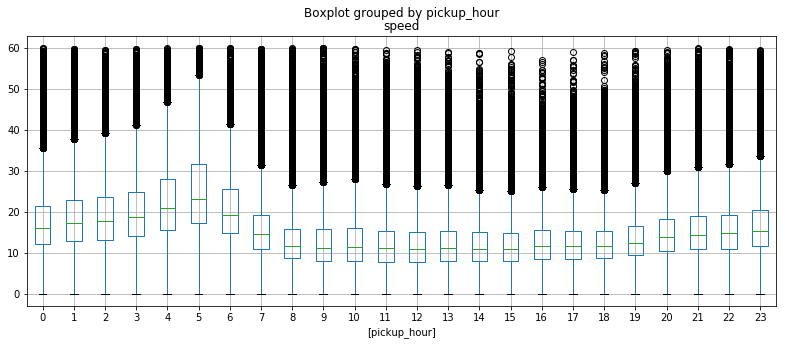

In [27]:
metric = 'pickup_hour'
y = 'speed'
train.boxplot(column=y, by=[metric])

Looks like speed is lower in the middle of the day which makes pickup hour a likely useful feature.

Plot other features. Do they seem useful?

## Clustering based on lat and long

In [28]:
places = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [29]:
places.shape

(2873768, 2)

In [30]:
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(places)

In [31]:
# here the new features is the id of the cluster
train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])

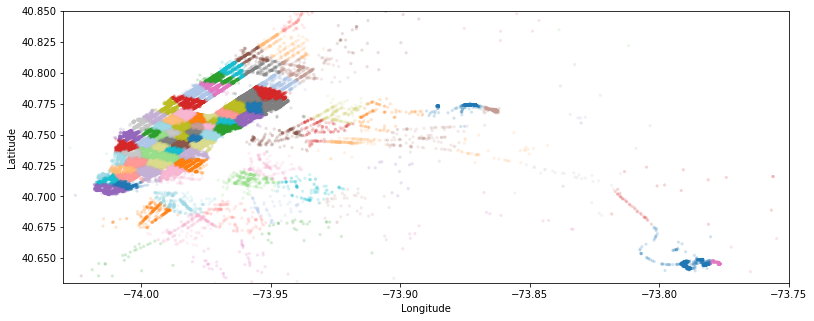

In [32]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#There are some weird outliers here

## Split train and validation

In [50]:
# split train and validation
np.random.seed(3)
n = train.shape[0]
inx = np.random.permutation(n)
n_sample = int(0.8*n)
train_set = train[train.index.isin(inx[:n_sample])]
val_set = train[~train.index.isin(inx[:n_sample])]
print(train_set.shape, val_set.shape)

(1132432, 21) (304452, 21)


## Target Encoding

Here is an example of what is called 'Target Encoding'. The idea here is given a categorical variable, create a new variable that is the mean each categorical value variable in the training data. 

Note that I divided the train and validation sets before doing this. Since the computation of these involve the target variable, we do it in the training and transfer it to the test/ validation sets.

In [51]:
col = 'pickup_weekday'
gby = train_set.groupby(col).mean()[['speed', 'log_trip_duration']]
gby.columns = ['%s_gby_%s' % (c, col) for c in gby.columns]
gby

,speed_gby_pickup_weekday,log_trip_duration_gby_pickup_weekday
pickup_weekday,,
0,15.339333,6.426580
1,13.943331,6.489515
2,13.678195,6.508185
3,13.633336,6.523769
4,13.956837,6.492975
5,15.100131,6.423035
6,16.934209,6.382548


In [52]:
for col in ['pickup_weekday', 'pickup_weekofyear', 'pickup_hour',
       'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train_set.groupby(col).mean()[['speed', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (c, col) for c in gby.columns]
    train_set = pd.merge(train_set, gby, how='left', left_on=col, right_index=True)
    val_set = pd.merge(val_set, gby, how='left', left_on=col, right_index=True)

In [53]:
train_set.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,speed_gby_pickup_weekofyear,log_trip_duration_gby_pickup_weekofyear,speed_gby_pickup_hour,log_trip_duration_gby_pickup_hour,speed_gby_pickup_week_hour,log_trip_duration_gby_pickup_week_hour,speed_gby_pickup_cluster,log_trip_duration_gby_pickup_cluster,speed_gby_dropoff_cluster,log_trip_duration_gby_dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,14.665374,6.455068,12.609901,6.518595,13.201231,6.455929,12.895465,6.475764,11.998484,6.331560
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,14.559002,6.420156,12.628164,6.520481,10.902781,6.642295,12.407642,6.550932,15.513937,6.693328
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,14.277489,6.468054,13.751587,6.445565,13.211405,6.460727,14.240041,6.532009,16.980071,6.722948
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,15.238559,6.437351,12.641380,6.533850,13.559827,6.441382,16.213448,6.246779,14.767754,6.285370
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,...,14.496447,6.494842,16.214178,6.470391,14.712484,6.512308,14.848871,6.379901,13.709720,6.393274


## Initial model

In [54]:
ind = [4, 5, 6, 7, 8, 13] + list(range(15, 33))
features = train_set.columns[ind]
features

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'pickup_weekday',
       'pickup_weekofyear', 'pickup_hour', 'pickup_week_hour',
       'pickup_cluster', 'dropoff_cluster', 'speed_gby_pickup_weekday',
       'log_trip_duration_gby_pickup_weekday', 'speed_gby_pickup_weekofyear',
       'log_trip_duration_gby_pickup_weekofyear', 'speed_gby_pickup_hour',
       'log_trip_duration_gby_pickup_hour', 'speed_gby_pickup_week_hour',
       'log_trip_duration_gby_pickup_week_hour', 'speed_gby_pickup_cluster',
       'log_trip_duration_gby_pickup_cluster', 'speed_gby_dropoff_cluster',
       'log_trip_duration_gby_dropoff_cluster'],
      dtype='object')

In [56]:
train_set.shape

(1132432, 33)

In [57]:
from sklearn.ensemble import RandomForestRegressor
t0 = dt.datetime.now()
rf = RandomForestRegressor(n_estimators=100, n_jobs=2)
train_y = train_set['log_trip_duration'].values
rf.fit(train_set[features], train_y)
t1 = dt.datetime.now()
print('Time fitting random forest: %i seconds' % (t1 - t0).seconds)

Time fitting random forest: 812 seconds


In [58]:
predictions = rf.predict(val_set[features])

In [73]:
val_y = val_set['log_trip_duration'].values
res = pd.DataFrame({'pred': predictions, 'y':val_y})
res.head(10)

,pred,y
0,6.481573,6.496775
1,6.395584,6.093570
2,6.938084,7.015712
3,7.224932,7.183112
4,6.089835,6.047372
5,7.786422,7.818028
6,6.673969,6.542472
7,6.291562,6.793466
8,7.023698,6.929517
9,6.213491,6.561031


In [60]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(val_y,predictions))

0.32109969374703357

I have not been able to get this to work

In [ ]:
# here is the list of parameters
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
xgb_pars = {'eta': 0.1,
            'subsample': 0.5, 'lambda': 1.,  'silent': 0,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [ ]:
# initially training on a subset of the data
train_set = train_set[:500000]
train_set.shape

train_X = train_set[features].as_matrix()
val_X = val_set[features].as_matrix()
train_y = train_set['log_trip_duration'].values
val_y = val_set['log_trip_duration'].values

In [ ]:
# train xgboost model
t0 = dt.datetime.now()
gbm = xgb.XGBClassifier(n_estimators=10, learning_rate=0.1, max_depth=3, subsample=0.5)
gbm.fit(train_X, train_y)
t1 = dt.datetime.now()
print('Time fitting xgb: %i seconds' % (t1 - t0).seconds)

In [ ]:
predictions = gbm.predict(val_X)

## Features from external data

https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm
you can get this data with wget

wget https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm/downloads/fastest_routes_train_part_1.csv

## References

* https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
* https://www.slideshare.net/HJvanVeen/feature-engineering-72376750?trk=v-feed